In [1]:
# ---------------------------------------------------------
# CELL 1: Imports & Environment Setup
# Description: Import all libraries and check GPU availability.
# ---------------------------------------------------------
import os
import numpy as np
import pandas as pd
import pydicom
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Optional: check GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("✅ Environment ready!")


Num GPUs Available: 1
✅ Environment ready!


In [2]:
# ---------------------------------------------------------
# CELL 2: Load & Merge CSVs
# Description: Same logic as your original approach for RSNA dataset.
# ---------------------------------------------------------
dataset_path = "/kaggle/input/rsna-pneumonia-detection-challenge"
labels_path = os.path.join(dataset_path, "stage_2_train_labels.csv")
class_info_path = os.path.join(dataset_path, "stage_2_detailed_class_info.csv")

labels_df = pd.read_csv(labels_path)
class_info_df = pd.read_csv(class_info_path)

merged_df = pd.merge(labels_df, class_info_df, on='patientId')

labels_simple = merged_df[['patientId', 'Target']].drop_duplicates().reset_index(drop=True)
labels_simple['Target'] = labels_simple['Target'].map({0: 'Normal', 1: 'Pneumonia'})
labels_simple["patientId"] = labels_simple["patientId"].astype(str) + ".dcm"

print(labels_simple.head())
print(f"✅ Dataset loaded! Total rows: {len(labels_simple)}")


                                  patientId     Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm     Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm     Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb.dcm     Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm     Normal
4  00436515-870c-4b36-a041-de91049b9ab4.dcm  Pneumonia
✅ Dataset loaded! Total rows: 26684


In [3]:
# ---------------------------------------------------------
# CELL 3: Create TFRecords
# Description: Convert each DICOM to 128x128, normalize, stack 3 channels, write TFRecord.
# ---------------------------------------------------------
tfrecord_path = "/kaggle/working/pneumonia_data.tfrecords"

def serialize_example(image, label):
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.tobytes()])),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
    }
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

with tf.io.TFRecordWriter(tfrecord_path) as writer:
    for idx, row in labels_simple.iterrows():
        dicom_path = os.path.join(dataset_path, "stage_2_train_images", row['patientId'])
        dicom = pydicom.dcmread(dicom_path)
        
        img = dicom.pixel_array.astype(np.float32)
        img = cv2.resize(img, (128, 128))

        # Normalize [0,1]
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-10)
        
        # Stack grayscale to 3 channels
        img = np.stack([img]*3, axis=-1)
        
        label = 1 if row['Target'] == 'Pneumonia' else 0
        
        example = serialize_example(img, label)
        writer.write(example)

print(f"✅ TFRecords created at: {tfrecord_path}")


✅ TFRecords created at: /kaggle/working/pneumonia_data.tfrecords


In [8]:
# ---------------------------------------------------------
# CELL 4: Define Training Pipeline
# Description: Applies random noise & data augmentation for training.
# ---------------------------------------------------------
import random
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

# 1) Random noise function
def random_noise_mask(image):
    def _random_noise_np(img_np):
        h, w, c = img_np.shape
        # Smaller patch to avoid overshadowing the lungs
        mask_size = random.randint(h // 10, h // 8)
        x1 = random.randint(0, w - mask_size)
        y1 = random.randint(0, h - mask_size)
        noise = np.random.randint(0, 256, (mask_size, mask_size, c)).astype(np.float32)
        img_np[y1:y1+mask_size, x1:x1+mask_size, :] = noise
        return img_np
    
    image = tf.numpy_function(_random_noise_np, [image], tf.float32)
    image.set_shape((128, 128, 3))
    return image

# 2) Data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

# 3) Parse function for training
def parse_tfrecord_train(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_raw(example['image'], tf.float32)
    label = example['label']
    image = tf.reshape(image, (128, 128, 3))

    # Apply random noise
    image = random_noise_mask(image)
    # Apply data augmentation
    image = data_augmentation(image)

    return image, label

# Create the training dataset
dataset = tf.data.TFRecordDataset(tfrecord_path)
dataset = dataset.map(parse_tfrecord_train, num_parallel_calls=tf.data.AUTOTUNE)

# Split into train/val
train_size = int(0.8 * len(labels_simple))
# train_data = dataset.take(train_size).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
train_data = dataset.take(train_size).shuffle(1000).repeat().batch(32).prefetch(tf.data.AUTOTUNE)

val_data = dataset.skip(train_size).batch(32).prefetch(tf.data.AUTOTUNE)

print("✅ Training & validation datasets ready!")


✅ Training & validation datasets ready!


In [9]:
# ---------------------------------------------------------
# CELL 5: Define Inference Pipeline
# Description: No random noise or data augmentation. 
#              We'll use this to visualize Grad-CAM on a clean image.
# ---------------------------------------------------------
def parse_tfrecord_inference(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_raw(example['image'], tf.float32)
    label = example['label']

    image = tf.reshape(image, (128, 128, 3))
    return image, label

no_aug_dataset = tf.data.TFRecordDataset(tfrecord_path)
no_aug_dataset = no_aug_dataset.map(parse_tfrecord_inference, num_parallel_calls=tf.data.AUTOTUNE)
no_aug_dataset = no_aug_dataset.batch(1).prefetch(tf.data.AUTOTUNE)

print("✅ Inference dataset (no noise/aug) ready!")


✅ Inference dataset (no noise/aug) ready!


In [10]:
# ---------------------------------------------------------
# CELL 6: Build & Partially Unfreeze Model
# Description: Use ResNet50, unfreeze last block, pick a mid-depth layer for Grad-CAM.
# ---------------------------------------------------------
from tensorflow.keras.applications import ResNet50

def build_model_unfreeze():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    # 1) Freeze everything initially
    base_model.trainable = False

    # 2) Unfreeze from conv4_block1_out onward
    set_trainable = False
    for layer in base_model.layers:
        if layer.name == "conv4_block1_out":
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs=base_model.input, outputs=output)

    # Choose a mid-depth conv layer for Grad-CAM, e.g. conv4_block6_out
    global last_conv_layer_name
    last_conv_layer_name = "conv4_block6_out"

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

trained_model = build_model_unfreeze()
trained_model.summary()
print(f"✅ Model built. Using last conv layer for Grad-CAM: {last_conv_layer_name}")


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 21,094,401 (80.47 MB)

 Non-trainable params: 3,018,112 (11.51 MB)

✅ Model built. Using last conv layer for Grad-CAM: conv4_block6_out


In [12]:
import math


In [13]:
# ---------------------------------------------------------
# CELL 7: Train the Model
# Description: Use the training (noise+aug) dataset and validation set.
# ---------------------------------------------------------


steps_per_epoch = math.ceil(train_size / 32)
history = trained_model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    steps_per_epoch=steps_per_epoch
)


print("✅ Model training complete!")


Epoch 1/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 125s 146ms/step - accuracy: 0.7154 - loss: 0.5850 - val_accuracy: 0.8156 - val_loss: 0.4889
Epoch 2/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 93s 140ms/step - accuracy: 0.7663 - loss: 0.5005 - val_accuracy: 0.8158 - val_loss: 0.5295
Epoch 3/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 93s 140ms/step - accuracy: 0.7736 - loss: 0.4816 - val_accuracy: 0.8196 - val_loss: 0.4415
Epoch 4/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 134s 201ms/step - accuracy: 0.7782 - loss: 0.4797 - val_accuracy: 0.8156 - val_loss: 0.4697
Epoch 5/5
668/668 ━━━━━━━━━━━━━━━━━━━━ 94s 141ms/step - accuracy: 0.7801 - loss: 0.4716 - val_accuracy: 0.8196 - val_loss: 0.4883
✅ Model training complete!


In [14]:
# ---------------------------------------------------------
# CELL 8: Grad-CAM Utilities
# Description: No absolute gradient, using mid-depth layer for better resolution.
# ---------------------------------------------------------
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generates a Grad-CAM heatmap focusing on the top predicted class (or a chosen class).
    """
    grad_model = Model(
        inputs=[model.input],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # top predicted class
        loss = predictions[:, pred_index]

    # Compute gradients (no abs)
    grads = tape.gradient(loss, conv_outputs)
    
    # Pool gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by the corresponding gradient
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)

    # Normalize
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-10)
    return heatmap

def display_gradcam(img_path, model, last_conv_layer_name, alpha=0.4):
    """
    Loads an image, computes Grad-CAM, and overlays the heatmap on the original image.
    """
    from tensorflow.keras.preprocessing.image import load_img, img_to_array

    # Load & preprocess
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Load original with OpenCV
    orig = cv2.imread(img_path)
    orig = cv2.resize(orig, (128, 128))
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

    # Resize heatmap
    heatmap = cv2.resize(heatmap, (128, 128))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(orig, 1 - alpha, heatmap, alpha, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.title("Grad-CAM Visualization")
    plt.show()

print("✅ Grad-CAM utilities (no abs gradient, mid-depth layer) ready!")


✅ Grad-CAM utilities (no abs gradient, mid-depth layer) ready!


✅ Sample image saved as sample_image.jpg, label: 0


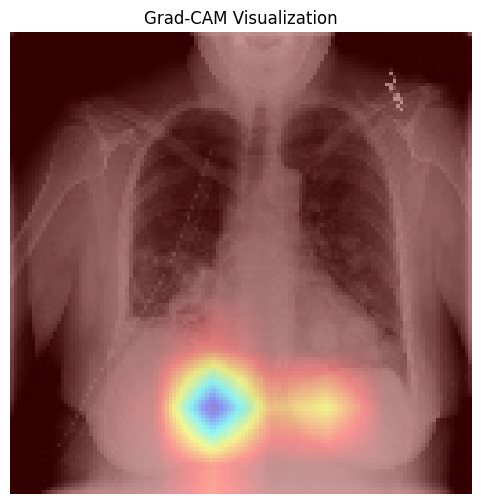

In [15]:
# ---------------------------------------------------------
# CELL 9: Test Grad-CAM
# Description: Pick a sample from the no-augment dataset, visualize Grad-CAM.
# ---------------------------------------------------------
sample_dataset = no_aug_dataset.take(1)
for img, lbl in sample_dataset:
    test_img = img.numpy()
    test_label = lbl.numpy()
    break

# Convert to displayable format
test_img_uint8 = (test_img[0] * 255).astype(np.uint8)
sample_img_path = "sample_image.jpg"
cv2.imwrite(sample_img_path, test_img_uint8)
print(f"✅ Sample image saved as {sample_img_path}, label: {test_label[0]}")

# Run Grad-CAM
display_gradcam(sample_img_path, trained_model, last_conv_layer_name, alpha=0.4)
